In [1]:
import mujoco
import mediapy as media
import numpy as np
import time

In [38]:
xml = """
<mujoco model="fixed_sphere_with_moving_body">
    <compiler angle="degree" coordinate="local"/>
    <option timestep="0.01" gravity="0 0 -9.81"/>
    
    <worldbody>
        <!-- Fixed sphere -->
        <body name="fixed_sphere" pos="0 0 0">
            <geom type="sphere" size="1" rgba="0.5 0.5 0.5 0.3" contype="0" conaffinity="0"/>
        </body>
        
        <!-- Moving body -->
        <body name="moving_body" pos="0 0 -1">
            <joint name="ball_joint" type="ball" pos="0 0 1" limited="true" range="0 90"/>
            <geom type="sphere" size="0.1" rgba="1 0 0 1"/>
        </body>
    </worldbody>
    
    <actuator>
        <motor joint="ball_joint" ctrlrange="-1 1" ctrllimited="true"/>
    </actuator>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Simulation parameters
duration = 10  # simulation duration in seconds
time_step = model.opt.timestep
num_steps = int(duration / time_step)

# Initial force to apply
force_magnitude = 10.0

# Create a window to visualize the simulation
renderer = mujoco.Renderer(model)

camera = mujoco.MjvCamera()
camera.lookat = np.array([0, 0, 0])
camera.distance = 1
camera.elevation = -90
camera.azimuth = 90


# Get the index of the moving body
moving_body_id = model.body('moving_body').id

positions = []
frames = []

for step in range(num_steps):
    
    if step % 2 == 0:  # Apply force every 100 timesteps
        dir = np.random.uniform(-1,1,3)
        dir /= np.linalg.norm(dir)
        dir *= 5

        force = force_magnitude * dir
        data.xfrc_applied[moving_body_id, :3] = force  # Apply force in the x, y, z direction
        print(f"Applied force {force} at timestep {step}")

    # Step the simulation
    mujoco.mj_step(model, data)

    # Extract the position of the moving body
    moving_body_position = data.xpos[moving_body_id]

    # if moving_body_position[2] > 0:
    #     moving_body_position[2] = 0
    #     data.qpos[moving_body_id*3+2] = 0

    positions.append(moving_body_position.copy())
    print(f"Timestep {step}: Position of moving body: {moving_body_position}")

    # Render the scene
    renderer.update_scene(data)
    frame = renderer.render()
    frames.append(frame)

    
    #media.show_image(renderer.render())

    # Clear the applied force after application
    data.xfrc_applied[moving_body_id, :3] = 0

    # Slow down the simulation for visualization
    time.sleep(time_step)

media.show_video(frames, fps=60)

# Close the renderer
renderer.close()

# Verify that positions are on the surface of the sphere
for pos in positions:
    distance_from_origin = np.linalg.norm(pos)
    assert np.isclose(distance_from_origin, 1.0, atol=1e-2), f"Body not on sphere surface: {pos}"
    print(f"Verified position on sphere: {pos}")

# with mujoco.Renderer(model) as renderer:
#   mujoco.mj_forward(model, data)
#   renderer.update_scene(data)


#   media.show_image(renderer.render())

Applied force [-37.99282231  -3.85634777  32.27497537] at timestep 0
Timestep 0: Position of moving body: [ 0.  0. -1.]
Timestep 1: Position of moving body: [-9.03398104e-04 -9.16967219e-05 -9.99999588e-01]
Applied force [-43.92488291 -21.96427493  -9.39016974] at timestep 2
Timestep 2: Position of moving body: [-1.80591276e-03 -1.83303772e-04 -9.99998353e-01]
Timestep 3: Position of moving body: [-3.75070188e-03 -7.96958919e-04 -9.99992649e-01]
Applied force [-27.51916032   0.10307388 -41.74548108] at timestep 4
Timestep 4: Position of moving body: [-0.00569181 -0.00140983 -0.99998281]
Timestep 5: Position of moving body: [-0.00827601 -0.00201746 -0.99996372]
Applied force [-18.38434808  26.79863229  37.99801381] at timestep 6
Timestep 6: Position of moving body: [-0.01085206 -0.00262311 -0.99993767]
Timestep 7: Position of moving body: [-0.01386434 -0.00259131 -0.99990053]
Applied force [-35.06771742 -12.2950179   33.45276864] at timestep 8
Timestep 8: Position of moving body: [-0.01

Verified position on sphere: [ 0.  0. -1.]
Verified position on sphere: [-9.03398104e-04 -9.16967219e-05 -9.99999588e-01]
Verified position on sphere: [-1.80591276e-03 -1.83303772e-04 -9.99998353e-01]
Verified position on sphere: [-3.75070188e-03 -7.96958919e-04 -9.99992649e-01]
Verified position on sphere: [-0.00569181 -0.00140983 -0.99998281]
Verified position on sphere: [-0.00827601 -0.00201746 -0.99996372]
Verified position on sphere: [-0.01085206 -0.00262311 -0.99993767]
Verified position on sphere: [-0.01386434 -0.00259131 -0.99990053]
Verified position on sphere: [-0.01686295 -0.00255696 -0.99985454]
Verified position on sphere: [-0.02069188 -0.00281443 -0.99978194]
Verified position on sphere: [-0.0245003  -0.00306911 -0.99969511]
Verified position on sphere: [-0.02919176 -0.00344007 -0.99956791]
Verified position on sphere: [-0.03385406 -0.00380759 -0.99941953]
Verified position on sphere: [-0.03830681 -0.00534179 -0.99925175]
Verified position on sphere: [-0.04272131 -0.00687

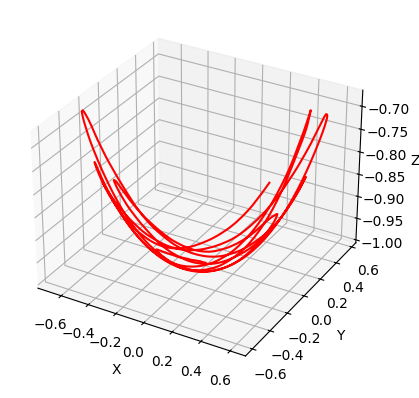

In [39]:
import matplotlib.pyplot as plt

positions = np.array(positions)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'r-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()